In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mabwiser.mab import MAB, LearningPolicy
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Carregar Dados

In [2]:
df = pd.read_csv('../dataset/processed/datset_processed.csv')
df.head()

,date,periodo_dia,reward,safra,dia_semana_qua,dia_semana_sab,usou_app_hoje,segmento_alto_valor,dia_semana_seg,tempo_cliente,dia_semana_sex,dias_desde_ultimo_clique,qtd_cliques_30d,segmento_baixo_valor
0,2024-01-01,noite,0,2024-01,0.0,0.0,0,0.0,1.0,831,0.0,69,1,1.0
1,2024-01-01,noite,0,2024-01,0.0,0.0,0,0.0,1.0,339,0.0,13,0,1.0
2,2024-01-01,noite,0,2024-01,0.0,0.0,0,1.0,1.0,448,0.0,81,0,0.0
3,2024-01-01,noite,1,2024-01,0.0,0.0,0,1.0,1.0,631,0.0,5,3,0.0
4,2024-01-01,manha,0,2024-01,0.0,0.0,1,0.0,1.0,159,0.0,86,1,0.0


# Preparação

In [3]:
le_action = LabelEncoder()
df["action"] = le_action.fit_transform(df["periodo_dia"])
df.head()

,date,periodo_dia,reward,safra,dia_semana_qua,dia_semana_sab,usou_app_hoje,segmento_alto_valor,dia_semana_seg,tempo_cliente,dia_semana_sex,dias_desde_ultimo_clique,qtd_cliques_30d,segmento_baixo_valor,action
0,2024-01-01,noite,0,2024-01,0.0,0.0,0,0.0,1.0,831,0.0,69,1,1.0,1
1,2024-01-01,noite,0,2024-01,0.0,0.0,0,0.0,1.0,339,0.0,13,0,1.0,1
2,2024-01-01,noite,0,2024-01,0.0,0.0,0,1.0,1.0,448,0.0,81,0,0.0,1
3,2024-01-01,noite,1,2024-01,0.0,0.0,0,1.0,1.0,631,0.0,5,3,0.0,1
4,2024-01-01,manha,0,2024-01,0.0,0.0,1,0.0,1.0,159,0.0,86,1,0.0,0


# Simulação

In [4]:
def create_models_cmab_mab(context_matrix, action_list):
    n_features = context_matrix.shape[1]
    arms = sorted(set(action_list))

    mab_contextual_lts = MAB(arms=arms, learning_policy=LearningPolicy.LinTS(), seed=2025, n_jobs=-1)
    mab_contextual_leg = MAB(arms=arms, learning_policy=LearningPolicy.LinGreedy(), seed=2025, n_jobs=-1)
    mab_contextual_lucb = MAB(arms=arms, learning_policy=LearningPolicy.LinUCB(), seed=2025, n_jobs=-1)
    
    mab_nao_contextual_ts = MAB(arms=arms, learning_policy=LearningPolicy.ThompsonSampling(), seed=2025, n_jobs=-1)
    mab_nao_contextual_eg = MAB(arms=arms, learning_policy=LearningPolicy.EpsilonGreedy(), seed=2025, n_jobs=-1)
    mab_nao_contextual_ucb = MAB(arms=arms, learning_policy=LearningPolicy.UCB1(), seed=2025, n_jobs=-1)
    
    
    mab_contextual_lts.partial = True
    mab_contextual_leg.partial = True
    mab_contextual_lucb.partial = True
    
    mab_nao_contextual_ts.partial = True
    mab_nao_contextual_eg.partial = True
    mab_nao_contextual_ucb.partial = True


    # Corrigir erro com dtype explícito
    mab_contextual_lts.fit(decisions=[], rewards=[], contexts=np.empty((0, n_features)))
    mab_contextual_leg.fit(decisions=[], rewards=[], contexts=np.empty((0, n_features)))
    mab_contextual_lucb.fit(decisions=[], rewards=[], contexts=np.empty((0, n_features)))
    
    
    mab_nao_contextual_ts.fit(decisions=[], rewards=[])
    mab_nao_contextual_eg.fit(decisions=[], rewards=[])
    mab_nao_contextual_ucb.fit(decisions=[], rewards=[])
    
    return mab_contextual_lts, mab_contextual_leg, mab_contextual_lucb, mab_nao_contextual_ts, mab_nao_contextual_eg, mab_nao_contextual_ucb


In [5]:
def predict_cmab_batch(contextos, true_actions, rewards, mab_contextual):
    preds = mab_contextual.predict(contexts=contextos)
    rewards_calc = [r if p == t else 0 for p, t, r in zip(preds, true_actions, rewards)]
    return preds, rewards_calc

def predict_mab_batch(true_actions, rewards, mab_nao_contextual):
    preds = [mab_nao_contextual.predict() for _ in true_actions]
    rewards_calc = [r if p == t else 0 for p, t, r in zip(preds, true_actions, rewards)]
    return preds, rewards_calc

In [6]:
def simulacao(df_enc):
    cols_not_contx = ['date', 'periodo_dia', 'reward', 'action', 'safra']
    cols_contx = [col for col in df_enc.columns if col not in cols_not_contx]

    X_contexto = df_enc[cols_contx]
    actions = df_enc['action'].tolist()

    mab_contextual_lts, mab_contextual_leg, mab_contextual_lucb, mab_nao_contextual_ts, mab_nao_contextual_eg, mab_nao_contextual_ucb = create_models_cmab_mab(X_contexto, actions)

    # Histórico
    cumulative_contextual_lts = 0
    cumulative_contextual_leg = 0
    cumulative_contextual_lucb = 0
    
    cumulative_nao_contextual_ts = 0
    cumulative_nao_contextual_eg = 0
    cumulative_nao_contextual_ucb = 0
    
    x_data = [] 
    y_cmab_lts = []
    y_cmab_leg = []
    y_cmab_lucb = []
    
    y_mab_ts = []
    y_mab_eg = []
    y_mab_ucb = []
    
    list_dates = sorted(set(df_enc['date'].unique()))
    # list_dates = list_dates[:10]

    for index, date in enumerate(list_dates):
        df_tmp = df_enc[df_enc['date']==date]

        contextos = df_tmp[cols_contx]
        true_actions = df_tmp['action'].tolist()
        rewards = df_tmp['reward'].tolist()

        # --- CMAB ---
        preds_ctx, rewards_ctx = predict_cmab_batch(contextos, true_actions, rewards, mab_contextual_lts)
        mab_contextual_lts.fit(decisions=preds_ctx, rewards=rewards_ctx, contexts=contextos)
        cumulative_contextual_lts += sum(rewards_ctx)
        
        preds_ctx, rewards_ctx = predict_cmab_batch(contextos, true_actions, rewards, mab_contextual_leg)
        mab_contextual_leg.fit(decisions=preds_ctx, rewards=rewards_ctx, contexts=contextos)
        cumulative_contextual_leg += sum(rewards_ctx)
        
        preds_ctx, rewards_ctx = predict_cmab_batch(contextos, true_actions, rewards, mab_contextual_lucb)
        mab_contextual_lucb.fit(decisions=preds_ctx, rewards=rewards_ctx, contexts=contextos)
        cumulative_contextual_lucb += sum(rewards_ctx)
        
        
        # --- MAB ---
        preds_mab, rewards_mab = predict_mab_batch(true_actions, rewards, mab_nao_contextual_ts)
        mab_nao_contextual_ts.fit(decisions=preds_mab, rewards=rewards_mab)
        cumulative_nao_contextual_ts += sum(rewards_mab)
        
        preds_mab, rewards_mab = predict_mab_batch(true_actions, rewards, mab_nao_contextual_eg)
        mab_nao_contextual_eg.fit(decisions=preds_mab, rewards=rewards_mab)
        cumulative_nao_contextual_eg += sum(rewards_mab)
        
        preds_mab, rewards_mab = predict_mab_batch(true_actions, rewards, mab_nao_contextual_ucb)
        mab_nao_contextual_ucb.fit(decisions=preds_mab, rewards=rewards_mab)
        cumulative_nao_contextual_ucb += sum(rewards_mab)

            
        # Gráfico =============
        x_data.append(index+1)
        
        y_cmab_lts.append(cumulative_contextual_lts)
        y_cmab_leg.append(cumulative_contextual_leg)
        y_cmab_lucb.append(cumulative_contextual_lucb)
        
        y_mab_ts.append(cumulative_nao_contextual_ts)
        y_mab_eg.append(cumulative_nao_contextual_eg)
        y_mab_ucb.append(cumulative_nao_contextual_ucb)
        
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(x_data, y_cmab_lts, label="LinTS (Contextual)")
        ax.plot(x_data, y_cmab_leg, label="LinGreedy (Contextual)")
        ax.plot(x_data, y_cmab_lucb, label="LinUCB (Contextual)")
        
        ax.plot(x_data, y_mab_ts, label="ThompsonSampling (Não-Contextual)", linestyle="--")
        ax.plot(x_data, y_mab_eg, label="EpsilonGreedy (Não-Contextual)", linestyle="--")
        ax.plot(x_data, y_mab_ucb, label="UCB (Não-Contextual)", linestyle="--")
        
        ax.set_xlabel("Interações")
        ax.set_ylabel("Recompensa acumulada")
        ax.set_title(f"CMAB vs MAB - Interação ({index+1}/{len(list_dates)})")
        ax.legend()
        # ax.grid(True)
        plt.tight_layout()
        plt.show()


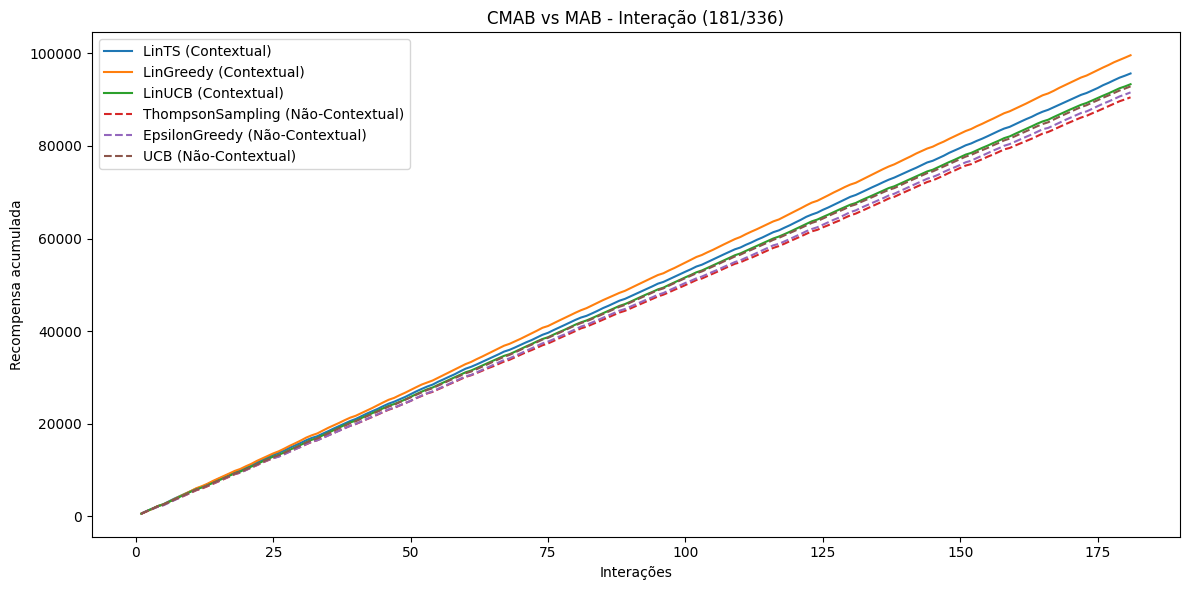

KeyboardInterrupt: 

In [7]:
simulacao(df)